In [1]:
import IPython.core.display as di
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)
#import seaborn as sns

This is merely a description of the analysis Rito and I did on Tuesday May 17th trying to figure out why the deconvolution code wasn't working. 
That is, we were trying to figure out why it was that the deconvolution of the given output was not giving us a symmetric input. 
It turns out that the code had been written in terms of position, while the time constant (tau) was in time. Also, we found that tau = .05s led to the most symmetric input.

Mira

In [53]:
import matplotlib.pyplot as pl
import pickle
import numpy as np
%matplotlib inline

file=open( '../../data/raw_data/20160428_1313_W1204_ref.pkl' , 'rb')
d=pickle.load(file)
file.close()


i = 8 
Nsize = 2**i #Number of data points
dt=(1/(d['sample freq'])) #period
T=dt*(Nsize) #full period
v=(d['speed']) #velocity
X = v*T #full distance
dx = dt*v #smallest amount of distance travelled
total_t = (d['scan time']) #how long it ran
    
total_s = (d['samples requested']) #number of samples 
startpt = ((total_s - Nsize)/2) #starting point
endpt = startpt + Nsize #ending point
    
y = (d['sig0F']) #This is the data I will call 'output'. It is raw data
A =np.hanning(Nsize)*y[startpt:endpt] #certain section of signal (removed: np.hanning(Nsize)*)
A=np.flipud(A)

A_f = np.fft.rfft(A)

a = d['delay0F']/v
t = a[startpt:endpt]
  
A_f = A_f[:-1]

It should be noted that the interferogram (output) was flipped up-down. This is because when running a simulated convolution and subsequent deconvolution program, we noticed that a symmetric input should lead to a higher peak on the left of a convoluted asymetric output (or left peak). This is shown in the graph below.

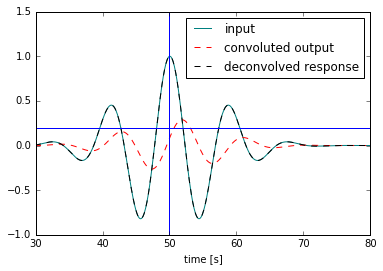

In [65]:
import numpy.fft as F
Ns=2**10
tt=np.linspace(0,100,Ns) # in seconds
dt=tt[2]-tt[1]
ff=np.linspace(0,0.5/dt,np.floor(Ns/2)) # in Hz
ff_full=np.linspace(0,0.5/dt,np.floor(Ns/2)+1)# in Hz, this is because rfft gives Ns/2+1 dim output

##ff_full is one more of ff

#test impulse
f0=0.1 # Hz
yt=np.exp(-0.01*(tt-tt[Ns/2])**2)*np.cos(2*np.pi*1.1*f0*(tt-tt[Ns/2])) #pulse
yf=F.rfft(yt)

# Convolution kernel corresponding to a RC time constant (i.e. exponential decay)
tau = 50*dt # seconds, some RC value chosen in multiples of the digital dt
K_f = 1/(1+1j*2*np.pi*ff_full*tau) #fourier transform of k 1j is i, ff_full is frequency axis

# convlution response 
pl.plot(tt,yt,'teal', label='input')
pl.plot(tt,F.irfft(yf*K_f),'--r', label='convoluted output')#convoluted = inverse fourier transform of the fourier transform of yt*K_f
pl.plot(tt,F.irfft(F.rfft(F.irfft(yf*K_f)/tau)/K_f*tau),'--k', label='deconvolved response')
pl.axvline(x = 50)
pl.axhline(y = .2)
pl.xlim(30,80)
pl.ylim(-1, 1.5)
pl.xlabel('time [s]')
pl.legend()
pl.show()

Above it is clear that the original input (the blue) is symmetric about x = 50. The convoluted ouput (the dashed red line), or the simulated 'output', is asymmetric, and has a higher left peak then right peak. However, when deconvoluted it is symmetric again (black dashed line). 
This showed a possible importance of having the left peak be higher for the output to be deconvoluted into its original symmetric form.

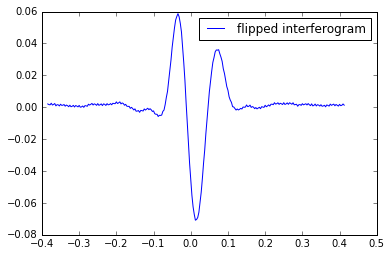

In [38]:
pl.plot(t,A, label ='flipped output')
pl.legend()
pl.show() 

Above it is clear that the right peak is lower than the left peak when the original interferogram is flipped.
However, despite the data now being represented in terms of time, rather than displacement, the deconvoluted interferogram was still asymetric (see below). 

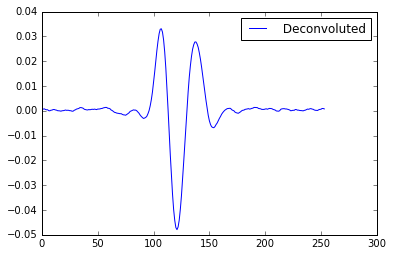

In [47]:
df = (1/T) #1/ number of points times smallest distance travelled (length of x axis)
f = df*np.arange(Nsize/2)+df/2.0 # .5number of points times length of x-axis
fFull = df*np.arange((Nsize/2) + 1)+df/2.0
tFull=1./fFull
Nu = f*(3*10**11)/(v)

tau = .03 #s [ in dimensions of 1/f]
k_v = 1/((1/tau)+1j*2*np.pi*f) #kernel *fourier transform of e^-t/Tau
n = 0.2#lower number filters out more high frequencies
sig = n*(2*np.pi)/(tau)           
H = (1/(sig*np.sqrt(2*np.pi)))*np.exp(-(f**2)/(2*sig**2)) #gaussian
B = H*A_f/k_v #fourier transform of interferogram times gaussian divided by kernel
c = np.fft.irfft(B) #inverse fourier transform of deconvolved spectrum
#pl.plot(tau, (np.max(c[0:118])-np.max(c[118:]))/np.abs(np.ptp(c)), '+k')
pl.plot (c, label = ' Deconvoluted')
pl.legend()
pl.show()

Above is the deconvoluted interferogram with tau = .03s. This tau was calculated experimentally using a chopper.  It is clear that there is still significant asymmetry, meaning there is something still being done incorrectly.
Therefore, we decided to test if changing the time constant would affect it, leading to more or less asymmetry in the deconvoluted interferogram.

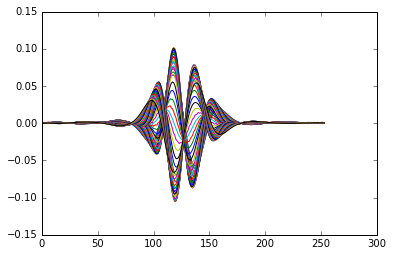

In [48]:
for ii in range(1,50,1):
    tau = (ii-25.00001)/100.0 #s [ in dimensions of 1/f]
    k_v = 1/((1/tau)+1j*2*np.pi*f) #kernel *fourier transform of e^-t/Tau
    n = 0.2#lower number filters out more high frequencies
    sig = n*(2*np.pi)/(tau)           
    H = (1/(sig*np.sqrt(2*np.pi)))*np.exp(-(f**2)/(2*sig**2)) #gaussian
    B = H*A_f/k_v #fourier transform of interferogram times gaussian divided by kernel
    c = np.fft.irfft(B) #inverse fourier transform of deconvolved spectrum
    #pl.plot(tau, (np.max(c[0:118])-np.max(c[118:]))/np.abs(np.ptp(c)), '+k')
    pl.plot(c, label=str(tau))
    
    #pl.plot (30*f,np.abs(A_f), label = 'convoluted spectrum') 
    #pl.plot(30*Nu, np.abs(B), label = 'deconvoluted spectrum')
    #pl.plot(30*Nu, np.abs(A_f)/55, label ='int')


#L=np.sum(np.abs(np.fft.rfft(c))/k_v*tau)
#pl.plot(300*NuFull, (1/L)*np.abs(np.fft.rfft(c))/k_v*tau, label = 'normalized spectrum')

#axes = pl.gca()
#axes.set_xlim([0,0.5*1e14])
#axes.set_ylim([0,12])
#pl.axvline(x=118)
#pl.legend()
pl.show()

Above we graphed several different deconvoluted interferograms with different time constants (from -.24 to .24 by intervals of .1) to see if any were more symmetric than the others. 
However it was obvious that it was much too difficult to try and distinguish by eye which of the multitude of time constants would be most symmetric. 

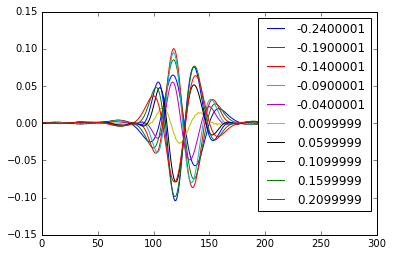

In [18]:
for ii in range(1,50,5):
    tau = (ii-25.00001)/100.0 #s [ in dimensions of 1/f]
    k_v = 1/((1/tau)+1j*2*np.pi*f) #kernel *fourier transform of e^-t/Tau
    n = 0.2#lower number filters out more high frequencies
    sig = n*(2*np.pi)/(tau)           
    H = (1/(sig*np.sqrt(2*np.pi)))*np.exp(-(f**2)/(2*sig**2)) #gaussian
    B = H*A_f/k_v #fourier transform of interferogram times gaussian divided by kernel
    c = np.fft.irfft(B) #inverse fourier transform of deconvolved spectrum
    #pl.plot(tau, (np.max(c[0:118])-np.max(c[118:]))/np.abs(np.ptp(c)), '+k')
    pl.plot(c, label=str(tau))
    
    #pl.plot (30*f,np.abs(A_f), label = 'convoluted spectrum') 
    #pl.plot(30*Nu, np.abs(B), label = 'deconvoluted spectrum')
    #pl.plot(30*Nu, np.abs(A_f)/55, label ='int')


#L=np.sum(np.abs(np.fft.rfft(c))/k_v*tau)
#pl.plot(300*NuFull, (1/L)*np.abs(np.fft.rfft(c))/k_v*tau, label = 'normalized spectrum')

#axes = pl.gca()
#axes.set_xlim([0,0.5*1e14])
#axes.set_ylim([0,12])
#pl.axvline(x=118)
pl.legend()
pl.show()

We tried again with fewer, but it was still too difficult. We decided instead to try to write figure out the asymmetry mathematically. We distinguished the line of symmetry, where one max peak was on one side and the other max peak on the other side, at x = 118. (see below, where there are fewer graphs to make it clearer).


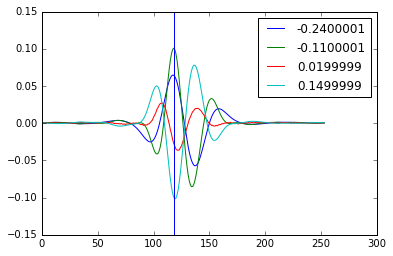

In [51]:
for ii in range(1,50,13):
    tau = (ii-25.00001)/100.0 #s [ in dimensions of 1/f]
    k_v = 1/((1/tau)+1j*2*np.pi*f) #kernel *fourier transform of e^-t/Tau
    n = 0.2#lower number filters out more high frequencies
    sig = n*(2*np.pi)/(tau)           
    H = (1/(sig*np.sqrt(2*np.pi)))*np.exp(-(f**2)/(2*sig**2)) #gaussian
    B = H*A_f/k_v #fourier transform of interferogram times gaussian divided by kernel
    c = np.fft.irfft(B) #inverse fourier transform of deconvolved spectrum
    #pl.plot(tau, (np.max(c[0:118])-np.max(c[118:]))/np.abs(np.ptp(c)), '+k')
    pl.plot(c, label=str(tau))
    
    #pl.plot (30*f,np.abs(A_f), label = 'convoluted spectrum') 
    #pl.plot(30*Nu, np.abs(B), label = 'deconvoluted spectrum')
    #pl.plot(30*Nu, np.abs(A_f)/55, label ='int')


#L=np.sum(np.abs(np.fft.rfft(c))/k_v*tau)
#pl.plot(300*NuFull, (1/L)*np.abs(np.fft.rfft(c))/k_v*tau, label = 'normalized spectrum')

#axes = pl.gca()
#axes.set_xlim([0,0.5*1e14])
#axes.set_ylim([0,12])
pl.axvline(x=118)
pl.legend()
pl.show()

We then wrote a function that determined the difference in peak heights on either side of the symmetry line (max y value on the left of the line of symmetry minus the max y value on the right of the line of symmetry), divided by the absolute value of the function's peak to peak. 
This would create a number that would be the differences in peak height on either side of the symmetry line, divided by its total amplitude from peak to peak.

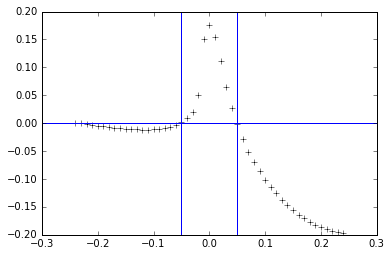

In [49]:
for ii in range(1,50,1):
    tau = (ii-25.00001)/100.0 #s [ in dimensions of 1/f]
    k_v = 1/((1/tau)+1j*2*np.pi*fFull) #kernel *fourier transform of e^-t/Tau
    n = 0.2#lower number filters out more high frequencies
    sig = n*(2*np.pi)/(tau)           
    H = (1/(sig*np.sqrt(2*np.pi)))*np.exp(-(f**2)/(2*sig**2)) #gaussian
    B = H*A_f/k_v #fourier transform of interferogram times gaussian divided by kernel
    c = np.fft.irfft(B) #inverse fourier transform of deconvolved spectrum
    pl.plot(tau, (np.max(c[0:118])-np.max(c[118:]))/np.abs(np.ptp(c)), '+k')
    pl.axhline(y=0)
    pl.axvline(x=.05)
    pl.axvline(x=-.05)
    #pl.plot(c, label=str(tau))
    
    #pl.plot (30*f,np.abs(A_f), label = 'convoluted spectrum') 
    #pl.plot(30*Nu, np.abs(B), label = 'deconvoluted spectrum')
    #pl.plot(30*Nu, np.abs(A_f)/55, label ='int')


#L=np.sum(np.abs(np.fft.rfft(c))/k_v*tau)
#pl.plot(300*NuFull, (1/L)*np.abs(np.fft.rfft(c))/k_v*tau, label = 'normalized spectrum')

#axes = pl.gca()
#axes.set_xlim([0,0.5*1e14])
#axes.set_ylim([0,12])
#pl.axvline(x=118)
#pl.legend()
pl.show()

This is the graph of the asymmetry as a function of tau. Here it became clear that there were two intersections where the asymmetry goes to zero. These happened to be at tau = +.05 and -.05!

This agreed with the mathematically expected result. As the kernal can be k_v = 1/(1+/-i(2pi)tau, the two numbers that should be the correct time constant should be +/-|tau|.

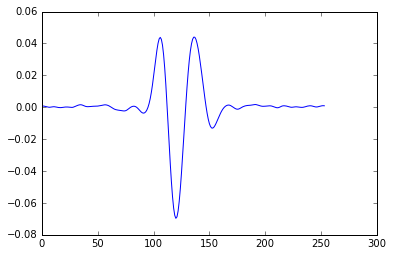

In [50]:
tau = .05 #s [ in dimensions of 1/f]
k_v = 1/((1/tau)+1j*2*np.pi*f) #kernel *fourier transform of e^-t/Tau
n = 0.2#lower number filters out more high frequencies
sig = n*(2*np.pi)/(tau)           
H = (1/(sig*np.sqrt(2*np.pi)))*np.exp(-(f**2)/(2*sig**2)) #gaussian
B = H*A_f/k_v #fourier transform of interferogram times gaussian divided by kernel
c = np.fft.irfft(B) #inverse fourier transform of deconvolved spectrum
#pl.plot(tau, (np.max(c[0:118])-np.max(c[118:]))/np.abs(np.ptp(c)), '+k')
pl.plot(c, label = 'aerga')

Plugging in .05s for tau, and deconvoluting the original output led to this! A nearly symmetric original input, suggesting that now the deconvolution is being done correctly.

Mira

And just for fun; the output and deconvolved interferogram superimposed, as well as the superimposed spectra! :)

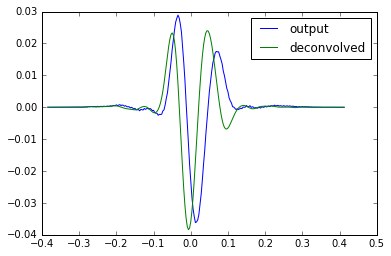

In [66]:
#spectrum
i = 8
Nsize = 2**i
dt=(1/(d['sample freq'])) #period
T=dt*(Nsize) #full period
v=(d['speed'])
X = v*T #full distance
dx = dt*v #smallest amount of distance travelled
total_t = (d['scan time']) #how long it ran
    
total_s = (d['samples requested']) #number of samples 
startpt = ((total_s - Nsize)/2) #starting point
endpt = startpt + Nsize #ending point
    
y = (d['sig0F']) 
A = np.hanning(Nsize)*y[startpt:endpt] #certain section of signal (removed: np.hanning(Nsize)*)
A=np.flipud(A)
A_f = np.fft.rfft(A) 

b = d['delay0F']/v
t = b[startpt:endpt]

df = (1/T) #1/ total period
f = df*np.arange(Nsize/2)+df/2.0 # .5number of points times length of x-axis
fFull = df*np.arange((Nsize/2) + 1)+df/2.0
tFull=1./fFull
Nu = f*(3*10**11)/(v)

tau = .05
k_v = 1/((1/tau)+1j*2*np.pi*fFull)
n = .2
sig = n*(2*np.pi)/(tau)           
H = (1/(sig*np.sqrt(2*np.pi)))*np.exp(-(fFull**2)/(2*sig**2))

B = H*A_f/k_v*tau
c = np.fft.irfft(B) #deconvoluted interferogram

L1=np.sum(np.abs(A))
pl.plot(t,A/L1, label = 'output')
L2 = np.sum(np.abs(c))
pl.plot(t, c/L2, label = 'deconvolved')

pl.legend()
pl.show()

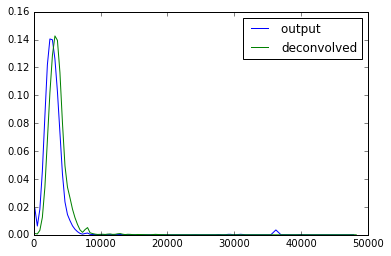

In [67]:
A_f1 = A_f[:-1]
L3=np.sum(np.abs(A_f1))
pl.plot(300*f, np.abs(A_f1)/L3, label = 'output ')
L4 = np.sum(np.abs(np.fft.rfft(c))/k_v*tau)
pl.plot(300*fFull, (np.abs(np.fft.rfft(c))/k_v*tau)/L4, label = 'deconvolved')
pl.legend()
pl.show()